## Propósito

O mercado de valores tem papel fundamental na economia de qualquer país ou mundo. Por dia, são negociados aproximadamente 5 trilhões de dólares americanos somente no mercado FOREX, que é o mercado de câmbio. Porém, esse mercado é somente um dos diversos que existem, e todos tem uma coisa em comum: a analise de gráficos. 

Diversas instituições já visam o mercado de Inteligencia artificial para terem ganhos mais consistentes, deixando de lado até mesmo experientes negociadores (Traders) e colocando as IA's para gerenciar grande parte das suas carteiras. E não é somente as grandes instituições que podem ter acesso a essa nova ferramenta, hoje em dia não há mais a nescessidade de grandes investimentos em infraestruturas para o treinamento de uma IA para a indentificação de alguns padrões no mercado financeiro. E nesse artigo estarei mostrando como pode ser simples o treinamento de uma IA para alguns padrões.  

## Objetivo

O objetivo desse artigo é mostrar o possivel uso de uma Inteligencia Artificial, com o uso de imagens, no mercado de valores e tambem deixar claro a facilidade de desenvolver uma IA para tal fim.

## Passo 1: Download de imagens de padrões e mercado lateral (Criação do banco de dados)

#### Padrões: Topo duplo/triplo e Ilha de reversão (IdR).

In [1]:
from duckduckgo_search import ddg_images
from fastcore.all import *

#função para buscar imagens
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

Buscar primeiramente por topo duplo

In [27]:
urls = search_images('double top', max_images=1)
urls[0]

Searching for 'double top'


'https://www.tradingwithrayner.com/wp-content/uploads/2018/06/Double-top-chart-pattern.png'

Fazer Download da imagem e mostrar, não utilizei o formato de 256x256 pois como é uma imagem que precisa de certa definição foi aumentada para 512x512

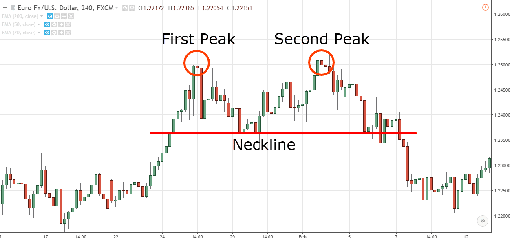

In [28]:
from fastdownload import download_url
dest = 'td.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(512,512)

Agora vamos fazer o mesmo para o Topo triplo e para a ilha de reversão

Searching for 'triple top'


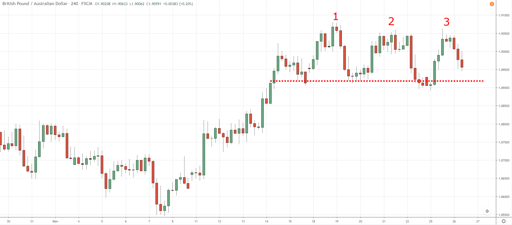

In [29]:
download_url(search_images('triple top', max_images=1)[0], 'tt.jpg', show_progress=False)
Image.open('tt.jpg').to_thumb(512,512)

Searching for 'reversal island'


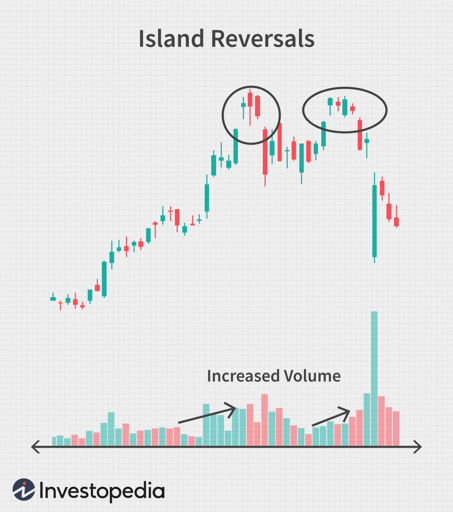

In [30]:
download_url(search_images('reversal island', max_images=1)[0], 'idr.jpg', show_progress=False)
Image.open('idr.jpg').to_thumb(512,512)

Os resultados pareceram promissores, por mais que eles estejam já indicados os padrões, veremos se isso influciará nos resultados, então vamos pegar algumas fotos para treino

In [16]:
searches = 'double top','reversal island','triple top'
path = Path('graficos')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    sleep(5)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} graph'))
    sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'double top'
Searching for 'double top graph'
Searching for 'reversal island'
Searching for 'reversal island graph'
Searching for 'triple top'
Searching for 'triple top graph'


## Passo 2: Treinamento do Modelo

Vamos retirar as imagens que não foram baixadas corretamente do nosso banco de dados

In [17]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print(f'{len(failed)} imagens falharam ao baixar')

0 imagens falharam ao baixar


Para treinar nosso modelo é preciso de uma forma de carregar nosso banco de dados de uma forma que possamos dividir entre parte de treino e parte para validação. Ultilizaremos a biblioteca do `Fastai` para fazer essa separação

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


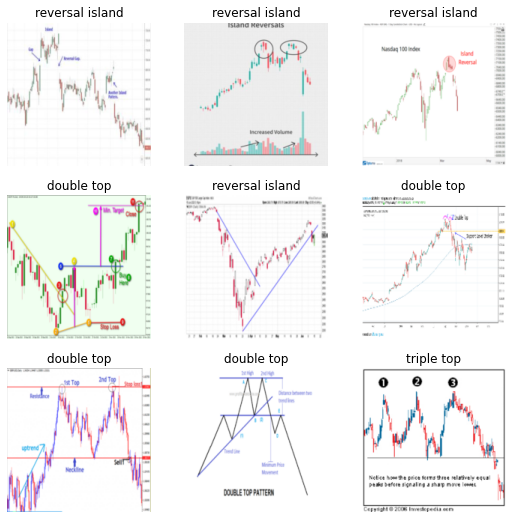

In [18]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),             # tipo de input e output
    get_items=get_image_files,                      # qual é o tipo de dado
    splitter=RandomSplitter(valid_pct=0.2, seed=42),# divisão dos dados entre teste e validação
    get_y=parent_label,                             # como saber o resultado real
    item_tfms=[Resize(192, method='squish')]        # diminuir o tamanho da imagem para menor utilização de maquina
).dataloaders(path, bs=70)

dls.show_batch(max_n=9)

Agora vamos colocar a Inteligencia Artificial para aprender:

In [20]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(6)

epoch,train_loss,valid_loss,error_rate,time
0,1.703411,1.705190,0.594937,00:32


epoch,train_loss,valid_loss,error_rate,time
0,0.896235,1.120056,0.367089,00:41
1,0.693505,0.658214,0.253165,00:42
2,0.543803,0.425684,0.139241,00:43
3,0.417883,0.343450,0.139241,00:44
4,0.335859,0.302133,0.126582,00:42
5,0.278632,0.289497,0.113924,00:43


Para finalizar vamos ver uma análise pela IA

Isso é um: double top.
Probabilidade de ser: 0.8088


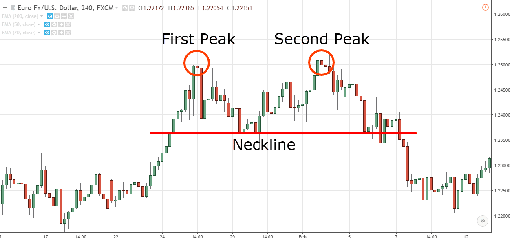

In [33]:
is_td,_,probs = learn.predict(PILImage.create('td.jpg'))
print(f"Isso é um: {is_td}.")
print(f"Probabilidade de ser: {probs[0]:.4f}")
Image.open('td.jpg').to_thumb(512,512)

## Conclusões

Podemos ver que pouca capacidade de processamento é possivel definir, e certo grau de acerto, dois padrões de gráfico.
Temos algumas ressalvas:

1- As imagens dos gráficos são muito parecidas entre si, então quanto mais padrões colocar para a IA aprender, menor será sua capacidade de acerto. Testes com somente 2 padrões (Topo duplo e Ilha de reversão conseguiram um resultado de mais de 99% de acerto)

2- Essa IA foi ensinada com imagens com indicações claras dos padrões, então para um uso em cenário real, recomenda-se um treinamento com imagens tiradas diretamente da plataforma de negociação (com o gráfico sem inidicadores técnicos);

Essa IA pode ser usada também para padrões de Candle (gráfico de velas) e análise técnica com a ultilização de indicadores. Portanto, fica claro sua utilidade para o mercado de valores.